In [1]:
import pickle5 as pickle
import json
from sklearn.metrics import ndcg_score
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import eval
import utils as ut

### Run parameters

In [2]:
plot_individual_results = False
score_column = 'coefficient'

### Load benchmark and results

In [3]:
# load benchmark
with open('../../data/commonsense_benchmark/v3/commonsense_benchmark_for_analysis.json', 'r') as f:
    benchmark = json.load(f)

In [4]:
# load explanations
results_dir = '../../results/linklogic/num_samples/'
results = dict()
experiments = {'with parent--child path': '', 'without parent--child path': '_fb12'}

for experiment, exp_str in experiments.items():
    with open(f'{results_dir}/parents_analysis_ComplEx_all_logsum_True_alpha_0.2_n_1000{exp_str}.pickle', 'rb') as f:
        results[experiment] = pickle.load(f)

### Compute Metrics

In [5]:

metrics = []
feature_df_list = []

for i, bmk in enumerate(benchmark):

    if bmk['category'] == 'location':
        continue

    triple = bmk['query_triple']
    s_triple = ut.stringify_path(triple)

    bmk_df = eval.extract_bmk_paths_as_df(bmk)

    for experiment in experiments.keys():

        res = eval.get_results_for_query_triple(results[experiment], triple)

        if not res:
            continue
            
        feature_df = eval.extract_feature_df_from_results(res['linklogic_features'], bmk_df, score_column=score_column,
                                                          experiment=experiment, query_triple=s_triple)
        num_true_candidates = feature_df['label'].sum()

        if num_true_candidates == 0:
            continue

        feature_df_list.append(feature_df)
        
        y_true = [feature_df['label']]
        metrics.append({'experiment': experiment,
                        'ndcg: score heuristic': ndcg_score(y_true=y_true, y_score=[feature_df['baseline path score']]),
                        'ndcg: linklogic': ndcg_score(y_true=y_true, y_score=[feature_df['coefficient']]),
                        'ndcg: random': ndcg_score(y_true=y_true, y_score=[feature_df['random']]),
                        'num true': num_true_candidates,
                        'query triple': s_triple,
                        'kge score': float(res['query_triple_kge_score']),
                        'fidelity': res['linklogic_metrics']['test_acc']})

        if plot_individual_results:
            fig = px.scatter(feature_df, x='baseline path score', y='coefficient', color='label',
                             hover_data=["path"], title=f'features: {s_triple}')
            fig.show()

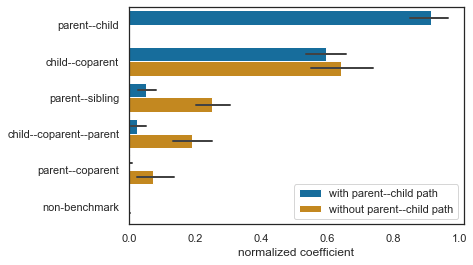

In [6]:
feature_data = pd.concat(feature_df_list, axis=0)

xcol = 'normalized ' + score_column
category_means = feature_data.groupby('bmk category')[xcol].mean()
category_order = list(category_means.sort_values(ascending=False).index)

sns.set(style="white")
p = sns.barplot(x=xcol, y="bmk category", hue="experiment", data=feature_data, palette="colorblind", 
                order=category_order, hue_order=['with parent--child path', 'without parent--child path'], errwidth=2)#, fliersize=1)
_ = p.set(ylabel=None)
_ = p.legend(loc='lower right')
plt.show()

In [7]:
def plot_scatter_with_facets(M, x, y, color, palette='matter', filename=None, size=8, width=700, height=300):
    fig = px.scatter(M, x=x, y=y, color=color, facet_col='experiment', 
                     hover_data=["query triple", "kge score"],
                     color_continuous_scale=palette, opacity=0.5, width=width, height=height)
    fig.add_shape(dict(type="line", x0=0, y0=0, x1=1.1, y1=1.1, line_width=1),
                       row="all", col="all",
                  line=dict(color="gray", width=1, dash="dot"))
    
    fig.update_traces(marker_size=size, marker_line={'width':0.5, 'color':'lightgrey'})
    
    fig.layout.plot_bgcolor = '#f0f0f0'
    fig.show()
    if filename is not None:
        fig.write_html(filename)

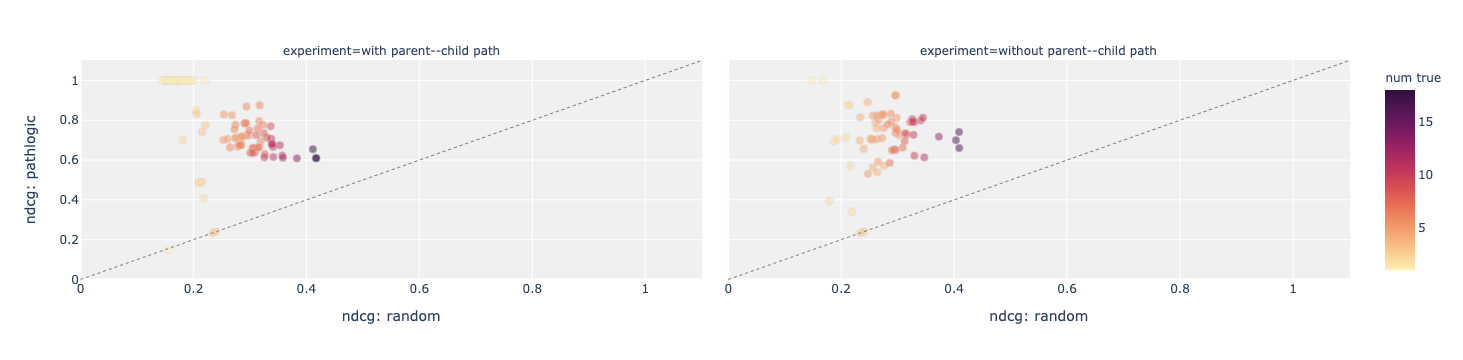

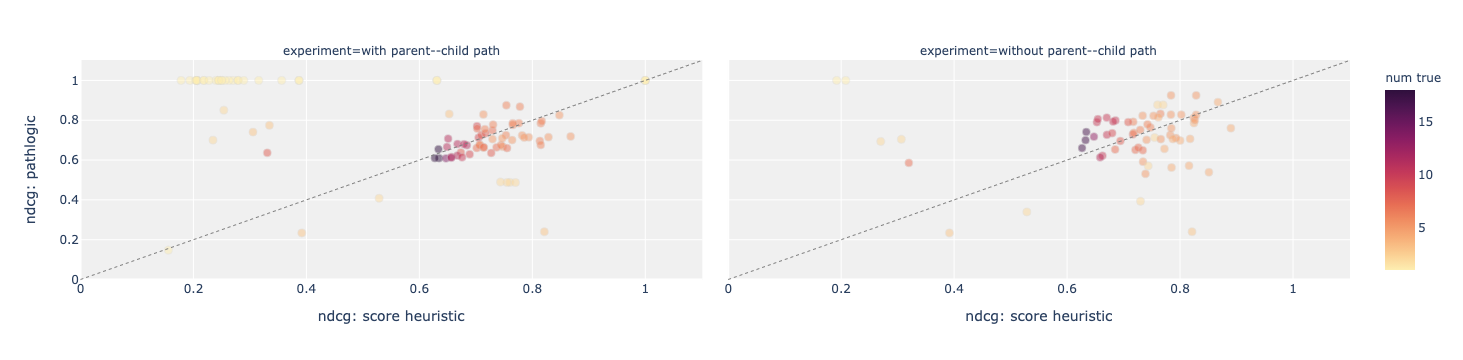

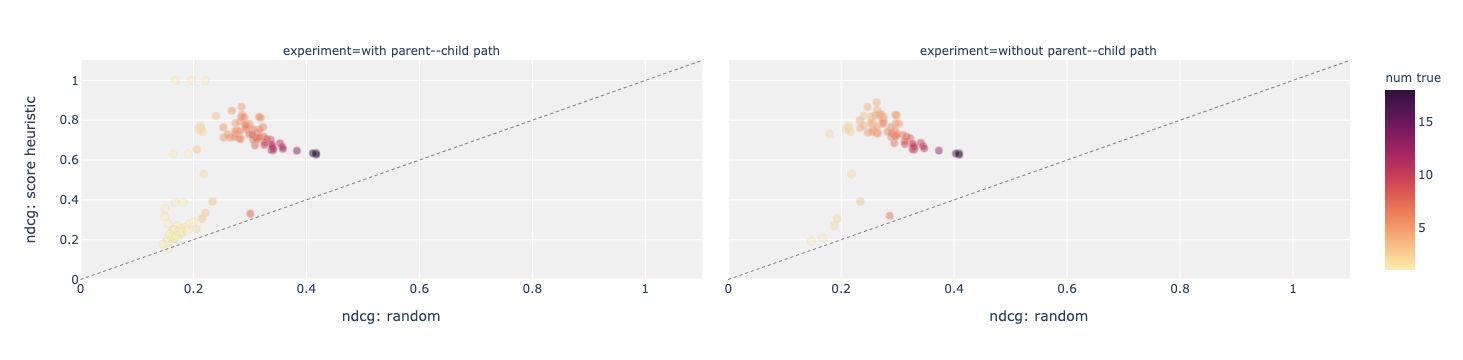

In [9]:
overlay = 'num true'
M = pd.DataFrame(metrics)  

plot_scatter_with_facets(M=M, x='ndcg: random', y='ndcg: linklogic', color=overlay, filename=None)
plot_scatter_with_facets(M=M, x='ndcg: score heuristic', y='ndcg: linklogic', color=overlay, filename=None)
plot_scatter_with_facets(M=M, x='ndcg: random', y='ndcg: score heuristic', color=overlay, filename=None)

In [15]:
M.groupby('experiment')[['ndcg: random', 'ndcg: score heuristic', 'ndcg: linklogic']].mean()

,ndcg: random,ndcg: score heuristic,ndcg: linklogic
experiment,,,
with parent--child path,0.253658,0.576383,0.774249
without parent--child path,0.277726,0.700539,0.715680
